In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
dataset = pd.read_csv('dataset.csv')


In [3]:
# Select relevant features for clustering and classification
features = dataset[['Unix TimeStamp', 'Source port', 'Destination port', 'Protocol', 'TTL', 'TOS', 'Datagram Length', 'A', 'P', 'R', 'S', 'F', 'Win', 'TCP length', 'TCP options']]
target = dataset['Priority']  # Assuming 'Priority' is the target variable for classification


# 1. Clustering Model (K-Means)

In [4]:
n_clusters = 3  # You can adjust this based on your analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
dataset['Cluster'] = kmeans.fit_predict(features)

In [5]:
# Display the results of the Clustering Model
cluster_results = dataset[['Priority', 'Cluster']]

# Print the count of instances in each cluster
print("Count of instances in each cluster:")
print(cluster_results['Cluster'].value_counts())

# Print the distribution of 'Priority' within each cluster
for cluster_label in range(n_clusters):
    print(f"\nCluster {cluster_label}:")
    print(cluster_results[cluster_results['Cluster'] == cluster_label]['Priority'].value_counts())


Count of instances in each cluster:
1    17957
2     6174
0     1610
Name: Cluster, dtype: int64

Cluster 0:
2    1606
3       4
Name: Priority, dtype: int64

Cluster 1:
1    9612
3    4276
2    4069
Name: Priority, dtype: int64

Cluster 2:
3    2879
2    1831
1    1464
Name: Priority, dtype: int64


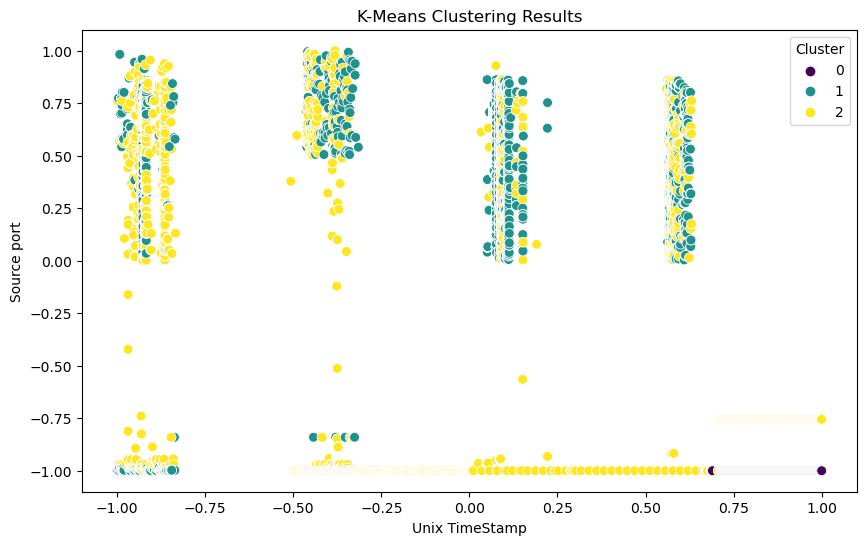

In [6]:
#'feature1' and 'feature2' are two features for visualization
feature1 = 'Unix TimeStamp'
feature2 = 'Source port'

# Scatter plot colored by clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dataset[feature1], y=dataset[feature2], hue=dataset['Cluster'], palette='viridis', s=50)
plt.title('K-Means Clustering Results')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend(title='Cluster')
plt.show()


# 2. Classification Model (Decision Tree)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [8]:
# Evaluate the classification model
y_pred = decision_tree_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy Score: 0.821712953971645
Precision Score: 0.8230710156408512
Recall Score: 0.821712953971645
F1 Score: 0.8216899372768466


In [9]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.79      0.84      0.81      2230
           2       0.77      0.73      0.75      1520
           3       0.93      0.90      0.92      1399

    accuracy                           0.82      5149
   macro avg       0.83      0.82      0.83      5149
weighted avg       0.82      0.82      0.82      5149



In [10]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[1873  294   63]
 [ 392 1103   25]
 [ 115   29 1255]]


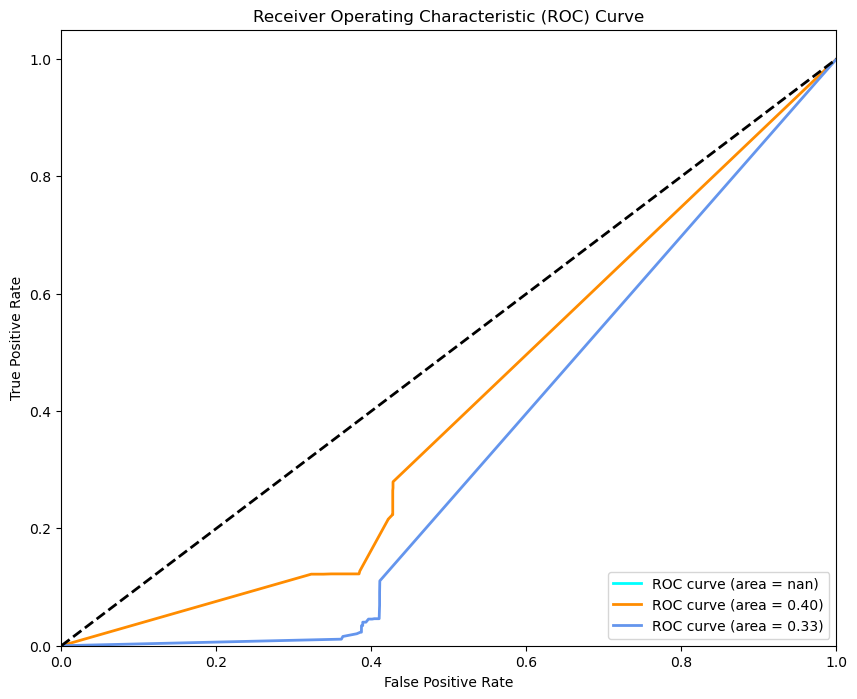

In [11]:
# Binarize the labels
y_bin = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], decision_tree_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


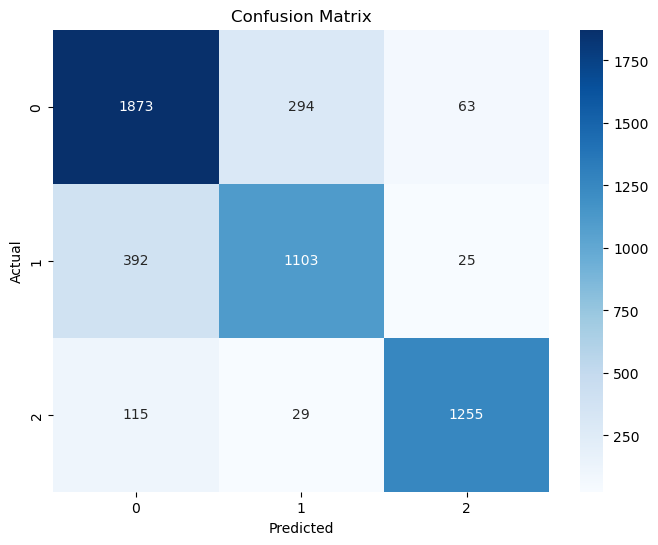

In [12]:
y_pred = decision_tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


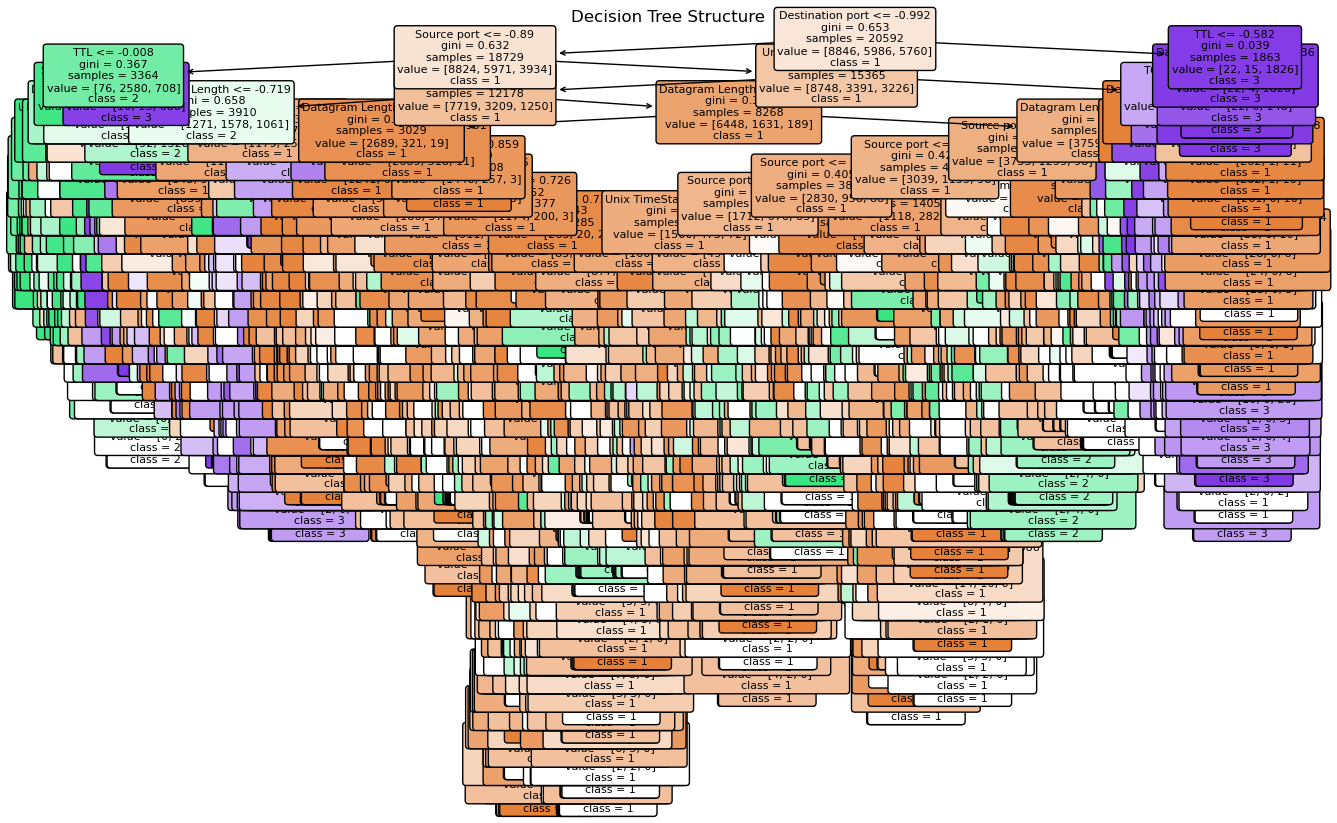

In [13]:
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_model, feature_names=features.columns, class_names=list(map(str, decision_tree_model.classes_)),
          filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Structure")
plt.show()


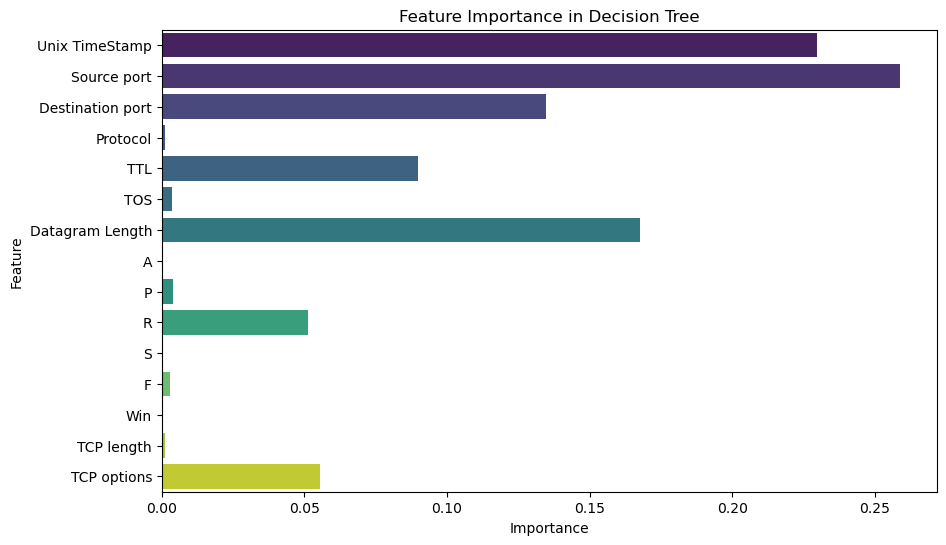

In [14]:
feature_importance = decision_tree_model.feature_importances_
feature_names = features.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names, palette='viridis')
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


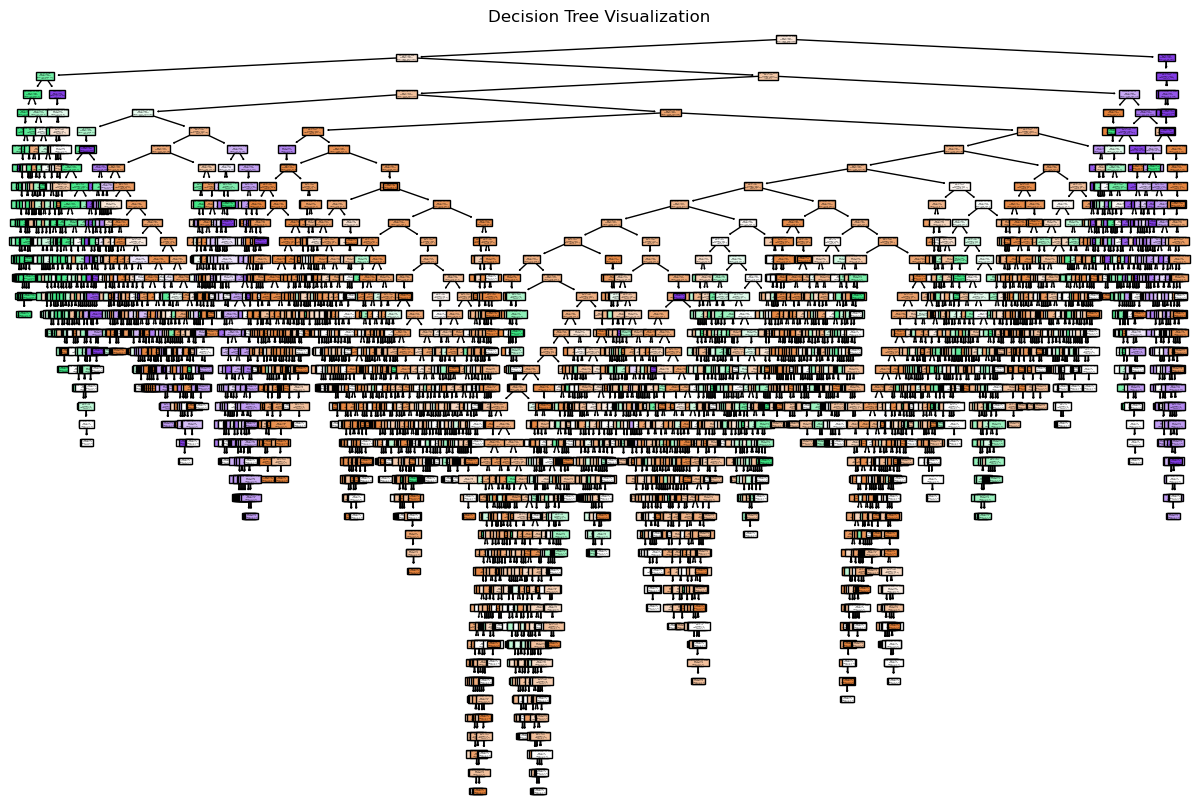

In [15]:
# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_model, filled=True, feature_names=features.columns, class_names=['0', '1', '2'])
plt.title("Decision Tree Visualization")
plt.show()


# 3. Anomaly Detection Model (Isolation Forest)

In [16]:
isolation_forest_model = IsolationForest(contamination=0.05, random_state=42) 
dataset['Anomaly'] = isolation_forest_model.fit_predict(features)

In [17]:
# Display results
print("Clusters:\n", dataset[['Priority', 'Cluster']])
print("Anomalies:\n", dataset[['Priority', 'Anomaly']])

Clusters:
        Priority  Cluster
0             3        2
1             3        2
2             3        2
3             3        1
4             3        1
...         ...      ...
25736         3        2
25737         3        2
25738         3        2
25739         2        0
25740         2        0

[25741 rows x 2 columns]
Anomalies:
        Priority  Anomaly
0             3        1
1             3       -1
2             3       -1
3             3       -1
4             3       -1
...         ...      ...
25736         3       -1
25737         3        1
25738         3        1
25739         2       -1
25740         2       -1

[25741 rows x 2 columns]


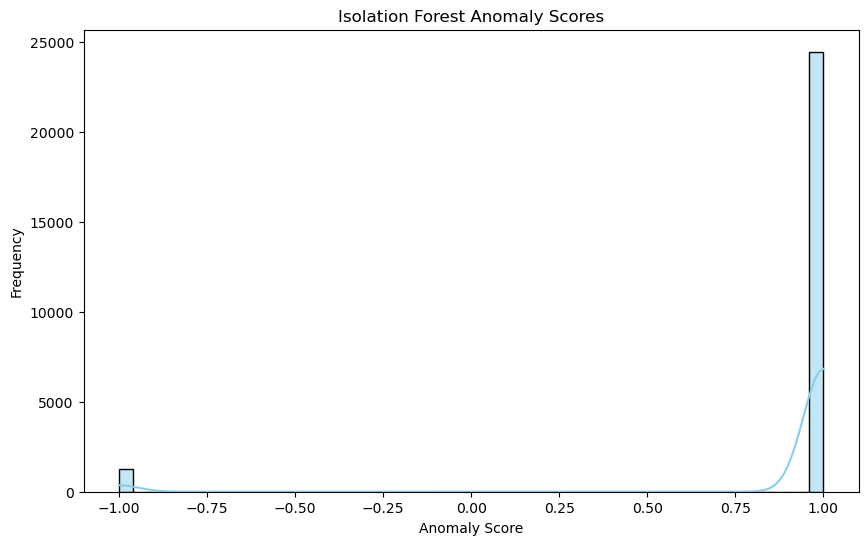

In [18]:
# 'Anomaly' column is added to the dataset
anomaly_scores = dataset['Anomaly']

# Plot histogram of anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(anomaly_scores, bins=50, kde=True, color='skyblue')
plt.title("Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


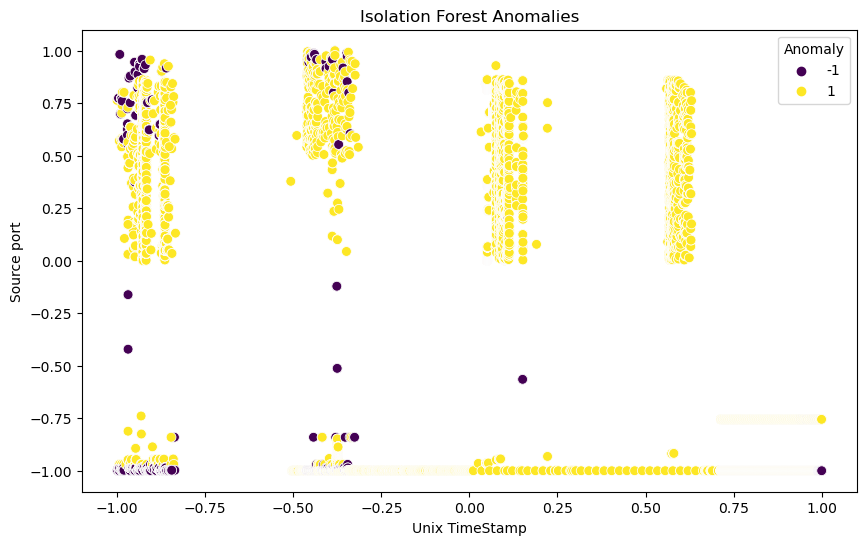

In [19]:
# 'feature1' and 'feature2' are two features for visualization
feature1 = 'Unix TimeStamp'
feature2 = 'Source port'

# Scatter plot with anomalies highlighted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dataset[feature1], y=dataset[feature2], hue=dataset['Anomaly'], palette='viridis', s=50)
plt.title('Isolation Forest Anomalies')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.legend(title='Anomaly')
plt.show()
